In [2]:
import sys
sys.path.append("/home/ubuntu/roaddetection/")

In [3]:
#!pip3 install sklearn --user

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from src.models.data import *
from src.models.metrics_img import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import np_utils

import pandas as pd
from sklearn.utils import shuffle

from PIL import Image

import rasterio as rio

%matplotlib inline

Using TensorFlow backend.


In [5]:
import os, shutil

original_dataset_dir = "../../data/train"

dirs = []

base_dir = "../../data"

In [6]:
imList = pd.read_csv('../visualize_imagery/numOfPixPerClassPerTile.csv')
imList = imList.drop(['Unnamed: 0'], axis = 1)
imList = shuffle(imList)
imList = imList[(imList['numPixel_pavedRoad'] != 0) | (imList['numPixel_unpavedRoad'] != 0)]
datasize = len(imList)
from sklearn.model_selection import train_test_split

train, test = train_test_split(imList, test_size=0.2)
trainSize   = len(train)
testSize    = len(test)

In [7]:
aug_train = dict(
    horizontal_flip = True,
    vertical_flip = True
)
aug_val = dict(
    horizontal_flip = False,
    vertical_flip = False
)

In [8]:
def satMapLoader(files, start, end):
    X = []
    Y = []
    for name in files[start:end].name.values:
        imSat = Image.open('../../data/train/sat/' + name)
        imMap = Image.open('../../data/train/map/' + name)
        x = np.array(imSat)#.read()
        y = np.array(imMap)#.read()
        y[y==127] = 1
        y[y==255] = 2
        X.append(x/255.)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = np_utils.to_categorical(np.asarray(Y), 3)
    return (X, Y)

def imageLoader(files, batch_size, data_gen_args, seed):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            seed = np.random.randint(100)
            limit = min(batch_end, L)
            X, Y = satMapLoader(files, batch_start, limit)
   
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen  = ImageDataGenerator(**data_gen_args)
            
            image_datagen.fit(X, augment=True, seed=seed)
            mask_datagen.fit(Y, augment=True, seed=seed)
            
            ima = image_datagen.flow(X, batch_size = batch_size, seed=seed)
            ma  = mask_datagen.flow(Y, batch_size = batch_size, seed=seed)

            yield (ima.next(), ma.next()) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [9]:
def viewer(imList, bs, data_gen_args, num):
    i = 1
    seed = 1
    im = (imageLoader(imList, bs, data_gen_args, seed))
    
    
    for a, b in (im):
        if i > num:
            return
        ix = 0
        for ix in range(len(a)):
            plt.imshow(a[ix])
            plt.show()
            plt.imshow(b[ix])
            plt.show()
    
        i+=1
        seed = np.random.randint(100)

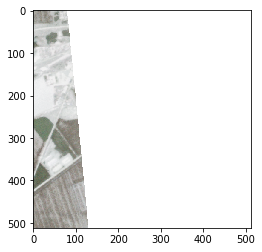

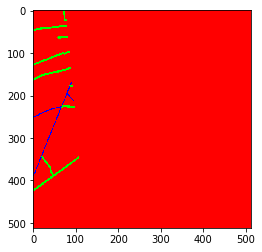

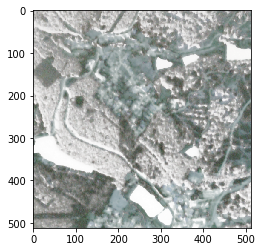

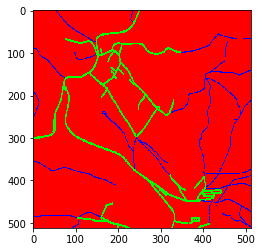

In [10]:
viewer(train, 2, aug_train, 1)

In [17]:
def get_fcn_vgg16_32s(input_size, n_classes, pretrained_weights=None):
    inputs = Input(input_size)

    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(512, (2, 2), activation='relu', padding="same")(x)
    
    x = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(8, 8), activation='linear', padding='same')(x)
    
    model = Model(input=inputs, output=x)
  
    model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [18]:
model = get_fcn_vgg16_32s((512, 512, 4),3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 512, 4)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512, 512, 4)       16        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      2368      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 128, 128, 256)     295168    
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


In [ ]:
model_checkpoint = ModelCheckpoint('../../models/fcnnLL_01_09_18_00.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(
    imageLoader(train, 32, aug_val, 1),
    steps_per_epoch=trainSize // 32,
    epochs=10,
    callbacks=[model_checkpoint],
    validation_data=imageLoader(test, 32, aug_val, 1),
    validation_steps=testSize // 32
)

Epoch 1/10
